# Page Rank Feature Selection algorithm evaluation

This notebook contains all the experiments that have been done to test the performance of the PageRank Feature Selection algorithm. It is part of the report of the final thesis of Josep Medialdea.

# Imports

In [35]:
import pandas as pd
from prfs.feature_selection import PageRankFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, SVC
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

# Dataset initialization

In [18]:
dataset_name = 'dice3'
drop_columns = []

dataset = pd.read_csv(f'datasets/{dataset_name}.csv').drop(columns=drop_columns)
features = dataset.iloc[:, 0:-1]
target = dataset.iloc[:,-1]

# Feature selection

In [52]:
prfs_params = {
    'graph':  'feature_label',
    'alpha':  'mutual_information',
    'beta':   'uncorrelation',
    'weight':  0.5
}

In [53]:
prfs = PageRankFeatureSelector(**prfs_params)
prfs.fit(features, target)
print(prfs.ranking())

RANKING
------
1: d_sum1
2: d_sum2
3: d1
4: d_sum3
5: d4
6: d3
7: i1
8: i3
9: i2
10: d2



# Classifier evaluation

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

accuracy_decision_tree = []
accuracy_naive_bayes = []
accuracy_svc = []

for n in range(len(features.columns)):
    clf = DecisionTreeClassifier()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    accuracy_decision_tree.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    
    clf = GaussianNB()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    accuracy_naive_bayes.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    
    clf = SVC()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    accuracy_svc.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    

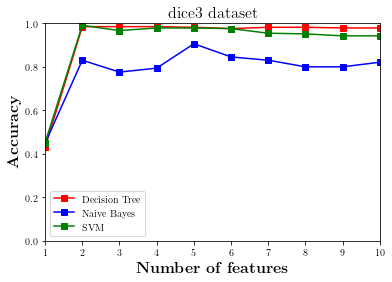

In [55]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'\textbf{Number of features}',fontsize=16)
plt.ylabel(r'\textbf{Accuracy}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(accuracy_decision_tree) + 1), accuracy_decision_tree, marker='s', color='r', label='Decision Tree')
plt.plot(range(1, len(accuracy_naive_bayes) + 1), accuracy_naive_bayes, marker='s', color='b', label='Naive Bayes')
plt.plot(range(1, len(accuracy_svc) + 1), accuracy_svc, marker='s', color='g', label='SVM')
plt.xlim([1, len(features.columns)])
plt.ylim([0, 1])
plt.legend()
plt.show()

# Regressor evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

r2_svm = []

for n in range(len(features.columns)):
    ref = SVR()
    ref.fit(X_train[prfs.select(n + 1)], y_train)
    r2_svm.append(ref.score(X_test[prfs.select(n + 1)], y_test))

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Number of features',fontsize=16)
plt.ylabel(r'\textbf{$R^2$}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(r2_svm) + 1), r2_svm, marker='s', color='r', label='SVM')
plt.xlim([1, len(features.columns)])
plt.ylim([0, 1])
plt.legend()
plt.show()